---
## Step 0: Load The Data

In [192]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = './data/train.p'
validation_file='./data/valid.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

### Data Summarry

In [193]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(list(y_train) + list(y_valid) + list(y_test)))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [87]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import numpy as np
import random
# Visualizations will be shown in the notebook.
%matplotlib inline


## Image Examples


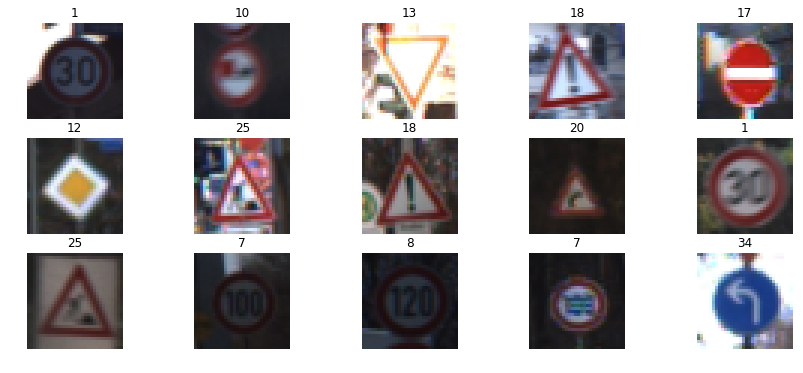

In [13]:
# show image of 15 random data points
fig, axs = plt.subplots(3,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(15):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])

## Label Frequency 

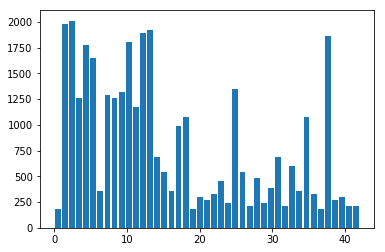

In [103]:
# histogram of label frequency
hist, bins = np.histogram(y_train, bins=n_classes)
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center')
plt.show()

This data is clearly not balanced. I will use data augmentation to increase the number of examples for the underrepresented classes. 

## Data Pre-Processing 
#### The following steps will be taken to pre-process and augment the data:
1. Convert all images to grayscale 
2. Normalize the images to (-1 ,1)
3. Augment the datasets so there is a uniform distribution of classes
    - Randomly scale, translate, rotate, and change the brightness to create new training images

In [194]:
# Convert to grayscale
X_train_rgb = X_train
X_train_gry = np.sum(X_train/3, axis=3, keepdims=True)

X_test_rgb = X_test
X_test_gry = np.sum(X_test/3, axis=3, keepdims=True)

print('RGB shape:', X_train_rgb.shape)
print('Grayscale shape:', X_train_gry.shape)

RGB shape: (34799, 32, 32, 3)
Grayscale shape: (34799, 32, 32, 1)


In [195]:
X_train = X_train_gry
X_test = X_test_gry
print('X_train shape:', X_train.shape)

X_train shape: (34799, 32, 32, 1)


In [196]:
# 2. Normalize images to (-1,1)

#before
print("X_train mean before normalization: ", np.mean(X_train))
print("X_test mean before normalization: ", np.mean(X_test))

X_train_normalized = (X_train - 128)/128 
X_test_normalized = (X_test - 128)/128

#after
print("")
print("X_train mean after normalization: ", np.mean(X_train_normalized))
print("X_test mean after normalization: ", np.mean(X_test_normalized))


X_train mean before normalization:  82.677589037
X_test mean before normalization:  82.1484603612

X_train mean after normalization:  -0.354081335648
X_test mean after normalization:  -0.358215153428


In [197]:
print(np.bincount(y_train))
print("minimum samples for any label:", min(np.bincount(y_train)))

[ 180 1980 2010 1260 1770 1650  360 1290 1260 1320 1800 1170 1890 1920  690
  540  360  990 1080  180  300  270  330  450  240 1350  540  210  480  240
  390  690  210  599  360 1080  330  180 1860  270  300  210  210]
minimum samples for any label: 180


In [198]:
X_train = X_train_normalized
X_test = X_test_normalized

In [199]:
print('Train X, y shapes:', X_train_normalized.shape, y_train.shape)
print('Test X, y shapes:', X_test.shape, y_test.shape)

Train X, y shapes: (34799, 32, 32, 1) (34799,)
Test X, y shapes: (12630, 32, 32, 1) (12630,)


## Basic LeNet Architecture 

In [77]:
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 128
modelLocation = './models/traffic_sign_model'


In [187]:
from tensorflow.contrib.layers import flatten
from tensorflow.contrib.layers import flatten

def LeNet(x, mu = 0, sigma = 0.1): 
    """
    Defines the network. `x` as input. 
    `mu` and `sigma`: Arguments used for tf.truncated_normal, randomly defines variables for 
                      the weights and biases for each layer
    """
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
        
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.  6 => 16
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x16. Output = 14x14x16.  6 => 16
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x64.  Input 6 => 16  Output 16 => 64
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 64), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(64))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x64. Output = 5x5x64.  16 => 64
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x64. Output = 400.  16 => 64    400 => 1600
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 1600. Output = 120. 400 => 1600  120 => 240
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1600, 240), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(240))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b    
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.  120 => 240
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(240, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
                        
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### LeNet Advanced 
A modified LeNet architecture based on [Traffic Sign Recognition with Multi-Scale Convolutional Networks](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf)



In [1]:
from tensorflow.contrib.layers import flatten


def LeNetAdvanced(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    weights1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma), name="weights1")
    x = tf.nn.conv2d(x, weights1, strides=[1, 1, 1, 1], padding='VALID')
    bias1 = tf.Variable(tf.zeros(6), name="bias1")
    x = tf.nn.bias_add(x, bias1)
    

    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer1 = x
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    weights2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma), name="weights2")
    x = tf.nn.conv2d(x, weights2, strides=[1, 1, 1, 1], padding='VALID')
    bias2 = tf.Variable(tf.zeros(16), name="bias2")
    x = tf.nn.bias_add(x, bias2)
                     
    # TODO: Activation.
    x = tf.nn.relu(x)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer2 = x
    
    # TODO: Layer 3: Convolutional. Output = 1x1x400.
    weights3 = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma), name="weights3")
    x = tf.nn.conv2d(x, weights3, strides=[1, 1, 1, 1], padding='VALID')
    bias3 = tf.Variable(tf.zeros(400), name="bias3")
    x = tf.nn.bias_add(x, bias3)
                     
    # TODO: Activation.
    x = tf.nn.relu(x)
    layer3 = x

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    layer2flat = flatten(layer2)
    print("layer2flat shape:",layer2flat.get_shape())
    
    # Flatten x. Input = 1x1x400. Output = 400.
    xflat = flatten(x)
    print("xflat shape:",xflat.get_shape())
    
    # Concat layer2flat and x. Input = 400 + 400. Output = 800
    x = tf.concat([xflat, layer2flat], 1)
    print("x shape:",x.get_shape())
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)
    
    # TODO: Layer 4: Fully Connected. Input = 800. Output = 43.
    weightsFinal = tf.Variable(tf.truncated_normal(shape=(800, 43), mean = mu, stddev = sigma), name="weightsFinal")
    biasFinal = tf.Variable(tf.zeros(43), name="biasFinal")    
    logits = tf.add(tf.matmul(x, weightsFinal), biasFinal)
    
    return logits

ImportError: No module named tensorflow.contrib.layers

### Train, Validate and Test the Model

In [201]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

tf.reset_default_graph() 

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) # probability to keep units
one_hot_y = tf.one_hot(y, 43)


def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


In [1]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

NameError: name 'LeNet' is not defined

In [79]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()


In [80]:
from sklearn.model_selection import train_test_split

X_train_normalized, y_train = shuffle(X_train_normalized, y_train)

X_train, X_validation, y_train, y_validation = train_test_split(X_train_normalized, y_train, 
                                                                test_size=0.20, random_state=42)

print("Old X_train size:",len(X_train_normalized))
print("New X_train size:",len(X_train))
print("X_validation size:",len(X_validation))

Old X_train size: 34799
New X_train size: 27839
X_validation size: 6960


In [83]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenetBasic')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.806

EPOCH 2 ...
Validation Accuracy = 0.900

EPOCH 3 ...
Validation Accuracy = 0.927

EPOCH 4 ...
Validation Accuracy = 0.945

EPOCH 5 ...
Validation Accuracy = 0.960

EPOCH 6 ...
Validation Accuracy = 0.958

EPOCH 7 ...
Validation Accuracy = 0.966

EPOCH 8 ...
Validation Accuracy = 0.962

EPOCH 9 ...
Validation Accuracy = 0.968

EPOCH 10 ...
Validation Accuracy = 0.974

Model saved


In [82]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./lenetBasic.meta')
    saver2.restore(sess, "./lenetBasic")
    test_accuracy = evaluate(X_test_normalized, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenetBasic
Test Set Accuracy = 0.908


## Lenet Advanced Training

In [203]:
rate = 0.001

logits = LeNetAdvanced(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver2 = tf.train.Saver()


EPOCHS = 60
BATCH_SIZE = 128
modelLocation = './models/traffic_sign_modelAdv'


layer 1 shape: (?, 28, 28, 6)
layer2flat shape: (?, 400)
xflat shape: (?, 400)
x shape: (?, 800)


In [204]:
X_train_normalized, y_train = shuffle(X_train_normalized, y_train)

X_train, X_validation, y_train, y_validation = train_test_split(X_train_normalized, y_train, 
                                                                test_size=0.20, random_state=42)

print("Old X_train size:",len(X_train_normalized))
print("New X_train size:",len(X_train))
print("X_validation size:",len(X_validation))

Old X_train size: 34799
New X_train size: 27839
X_validation size: 6960


In [205]:
epoch_validation = np.zeros((EPOCHS), dtype=np.float64)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        epoch_validation[i] = validation_accuracy
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenetAdv')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.854

EPOCH 2 ...
Validation Accuracy = 0.938

EPOCH 3 ...
Validation Accuracy = 0.963

EPOCH 4 ...
Validation Accuracy = 0.974

EPOCH 5 ...
Validation Accuracy = 0.977

EPOCH 6 ...
Validation Accuracy = 0.982

EPOCH 7 ...
Validation Accuracy = 0.984

EPOCH 8 ...
Validation Accuracy = 0.987

EPOCH 9 ...
Validation Accuracy = 0.988

EPOCH 10 ...
Validation Accuracy = 0.987

EPOCH 11 ...
Validation Accuracy = 0.989

EPOCH 12 ...
Validation Accuracy = 0.989

EPOCH 13 ...
Validation Accuracy = 0.988

EPOCH 14 ...
Validation Accuracy = 0.990

EPOCH 15 ...
Validation Accuracy = 0.990

EPOCH 16 ...
Validation Accuracy = 0.990

EPOCH 17 ...
Validation Accuracy = 0.990

EPOCH 18 ...
Validation Accuracy = 0.991

EPOCH 19 ...
Validation Accuracy = 0.990

EPOCH 20 ...
Validation Accuracy = 0.991

EPOCH 21 ...
Validation Accuracy = 0.990

EPOCH 22 ...
Validation Accuracy = 0.989

EPOCH 23 ...
Validation Accuracy = 0.991

EPOCH 24 ...
Validation Accura

In [206]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver3 = tf.train.import_meta_graph('./lenetAdv.meta')
    saver3.restore(sess, "./lenetAdv")
    test_accuracy = evaluate(X_test, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenetAdv
Test Set Accuracy = 0.944


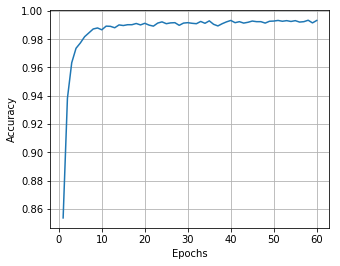

In [208]:
fig, axes = plt.subplots(ncols=1, figsize=(5, 4))
axes.plot(range(1, EPOCHS + 1), epoch_validation)
axes.set_xlabel('Epochs')
axes.set_ylabel('Accuracy')
axes.grid(True)

## Lenet Basic Results
### Params:
- Epochs: 10
- Batch size: 128
- Learning rate: .001
- Keep prob: 1.0

### Results:
- Validation accuracy: 97.4%
- Test set accuracy: 90.8%

## Lenet Advanced Results
### Params:
- Epochs: 60
- Batch size: 128
- Learning rate: .0008
- Keep prob: 0.5

### Results:
- Validation accuracy: 99.4%
- Test set accuracy: 93.4%

### Params:
- Epochs: 60
- Batch size: 128
- Learning rate: .001
- Keep prob: 0.5

### Results:
- Validation accuracy: 99.3%
- Test set accuracy: 94.4%
